In [1]:
#install libraries

!rm -r kdg
!git clone -b weighted_kdn https://github.com/NeuroDataDesign/kdg
!ls
!pip install kdg/.

rm: cannot remove 'kdg': No such file or directory
Cloning into 'kdg'...
remote: Enumerating objects: 5989, done.
remote: Counting objects: 100% (2890/2890), done.
remote: Compressing objects: 100% (2535/2535), done.
remote: Total 5989 (delta 797), reused 2365 (delta 353), pack-reused 3099
Receiving objects: 100% (5989/5989), 209.13 MiB | 33.08 MiB/s, done.
Resolving deltas: 100% (1752/1752), done.
kdg  sample_data
Processing ./kdg
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 14.5 MB 34 kB/s 
     |████████████████████████████████| 23.2 MB 1.2 MB/s 
  Created wheel for kdg: filename=kdg-0.0.1-py3-none-

In [2]:
# import modules
import numpy as np
from numpy.random import default_rng
from sklearn.ensemble import RandomForestClassifier as rf 
from tensorflow import keras
from keras import layers
from kdg.kdn import *
from kdg.utils import gaussian_sparse_parity, trunk_sim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# define the experimental setup
p = 20 # total dimensions of the data vector
p_star = 3 # number of signal dimensions of the data vector
'''sample_size = np.logspace(
        np.log10(10),
        np.log10(5000),
        num=10,
        endpoint=True,
        dtype=int
        )'''
sample_size = 5000 # sample size under consideration
n_test = 500 # test set size
nTrees = 100

compile_kwargs_rf = {
    "n_estimators": nTrees
    }

compile_kwargs_nn = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4)
    }
fit_kwargs = {
    "epochs": 150,
    "batch_size": 32,
    "verbose": False
    }

def get_kdf_weights(X_star, X_, forest):
    polytope_star = np.array(
        [tree.apply(X_star.reshape(1, -1)) for tree in forest.estimators_]
        ).T
    #print(polytope_star.shape)
    predicted_leaf_ids_across_trees = np.array(
        [tree.apply(X_) for tree in forest.estimators_]
        ).T

    matched_samples = np.sum(
        predicted_leaf_ids_across_trees == polytope_star,
        axis=1
    )
    #print(matched_samples)
    idx = np.where(
        matched_samples>0
    )[0]

    #X_star isn't included in X_ so need to scale this manually
    scale = matched_samples[idx]/polytope_star.shape[1]
      
    return np.array(scale)

def get_kdn_weights(X_star, X_, network, weighting_method="TM"):
    X = np.concatenate((X_star.reshape((1, -1)), X_))

    polytopes, polytope_memberships = network._get_polytope_memberships(X)

    # compute the weights
    weights = []

    #iterate through all the polytopes
    for n in range(len(polytopes)):    
        #calculate match
        match_status = []
        for layer_id in range(network.total_layers):
            layer_match = polytope_memberships[layer_id][n,:] == polytope_memberships[layer_id][0,:]
            match_status.append(layer_match.astype("int"))

        if weighting_method == 'TM':
            # weight based on the total number of matches (uncomment)
            match_status = np.concatenate(match_status)
            weight = np.sum(match_status) / match_status.shape[0]

        if weighting_method == 'FM':
            # weight based on the first mismatch (uncomment)
            match_status = np.concatenate(match_status)
            if len(np.where(match_status==0)[0]) == 0:
                weight = 1.0
            else:
                first_mismatch_idx = np.where(match_status==0)[0][0]
                weight = first_mismatch_idx / match_status.shape[0]

        if weighting_method == 'LL':
            # layer-by-layer weights
            weight = 0
            for layer in match_status:
                weight += np.sum(layer)/layer.shape[0]
            weight /= network.total_layers
            
        if weighting_method == 'AP':
            # activation path weights
            weight = 1
            for layer in match_status:
                weight *= np.sum(layer)/layer.shape[0]
        
        if weighting_method == 'flat' or weighting_method == None:
            # flat minimum weight
            weight = 1
            for layer in match_status:
                weight *= 1/layer.shape[0]
        
        weights.append(weight)
    
    return np.array(weights)

def getNN():
    network_base = keras.Sequential()
    network_base.add(layers.Dense(10, activation='relu', input_shape=(20,)))
    network_base.add(layers.Dense(5, activation='relu'))
    network_base.add(layers.Dense(5, activation='relu'))
    network_base.add(layers.Dense(units=2, activation = 'softmax'))
    network_base.compile(**compile_kwargs_nn)
    return network_base

In [30]:
# Generate experimental data

X, y = gaussian_sparse_parity(
    sample_size,
    p_star=p_star,
    p=p
)

X_test, y_test = gaussian_sparse_parity(
    n_test,
    p_star=p_star,
    p=p
)

# pick a random point from testing data 
rng = default_rng(0)
idx = rng.integers(0, n_test)
X_star = X_test[idx]

#generate a bunch of points
#distances = np.logspace(-20, 1, num=22, base=10)
distances = np.linspace(0, 10, num=100)
X_dist_static = {}
X_dist_noisy = {}
for d in distances:
  #print(d)
  rand_dist = rng.random((n_test, p_star))
  rand_dist = np.sqrt((d**2)*(rand_dist/np.sum(rand_dist, axis=1)[:,None]))
  static_noise = X_star[3:] + np.zeros((n_test, p-p_star))
  random_noise = 2*rng.random((n_test,p-p_star))-1
  X_dist_static[d] = np.concatenate((X_star[:3] + rand_dist, static_noise), axis=1)
  X_dist_noisy[d] = np.concatenate((X_star[:3] + rand_dist, random_noise), axis=1)

#%%
# train Vanilla RF, NN
vanilla_rf = rf(**compile_kwargs_rf).fit(X, y)

vanilla_nn = getNN()
vanilla_nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

model_kdn = kdn(network=vanilla_nn)

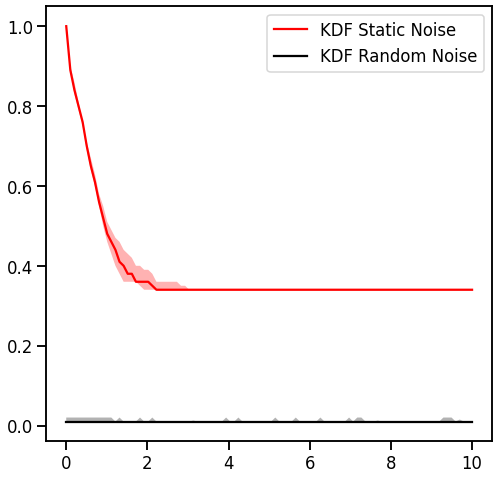

In [31]:


# plot distance vs. weights for KDF
weights_s = [get_kdf_weights(X_star, X_dist_static[d], vanilla_rf) for d in distances]
weight_med_s = [np.median(w) for w in weights_s]
weight_25q_s = [np.quantile(w, 0.25) for w in weights_s]
weight_75q_s = [np.quantile(w, 0.75) for w in weights_s]

weights_n = [get_kdf_weights(X_star, X_dist_noisy[d], vanilla_rf) for d in distances]
weight_med_n = [np.median(w) for w in weights_n]
weight_25q_n = [np.quantile(w, 0.25) for w in weights_n]
weight_75q_n = [np.quantile(w, 0.75) for w in weights_n]

sns.set_context('talk')

fig, ax = plt.subplots(1,1, figsize=(8,8))
#ax.set_xscale("log")
ax.plot(distances, weight_med_s, c="r", label='KDF Static Noise')
ax.plot(distances, weight_med_n, c="k", label='KDF Random Noise')
ax.fill_between(distances, weight_25q_s, weight_75q_s, facecolor='r', alpha=.3)
ax.fill_between(distances, weight_25q_n, weight_75q_n, facecolor='k', alpha=.3)
ax.legend()

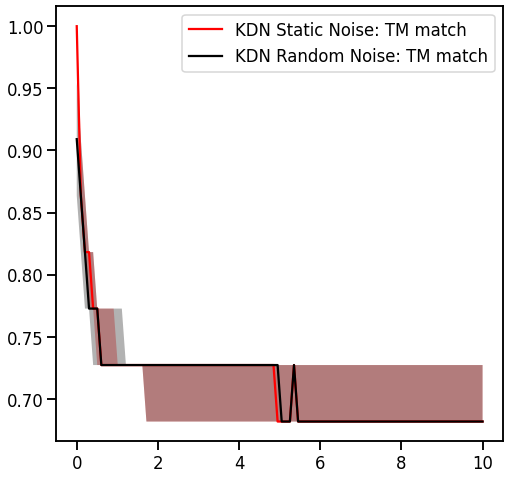

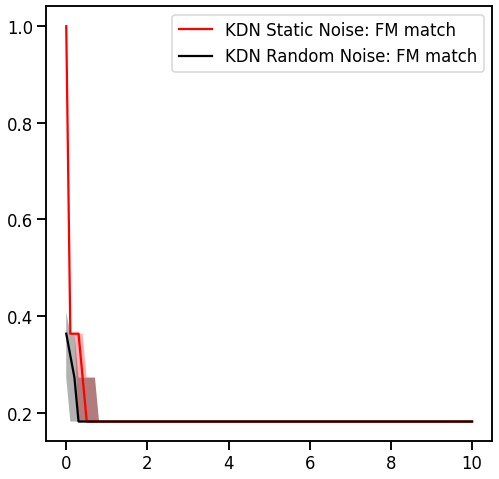

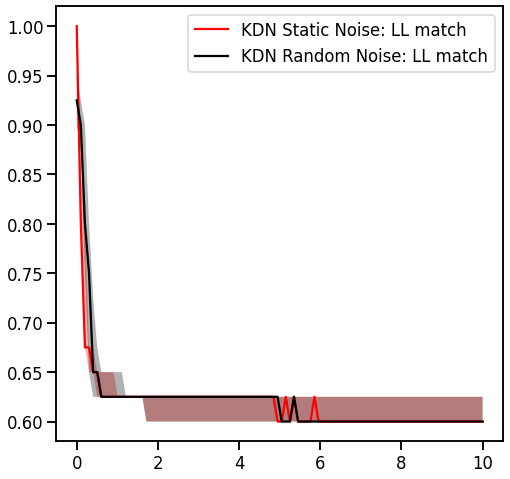

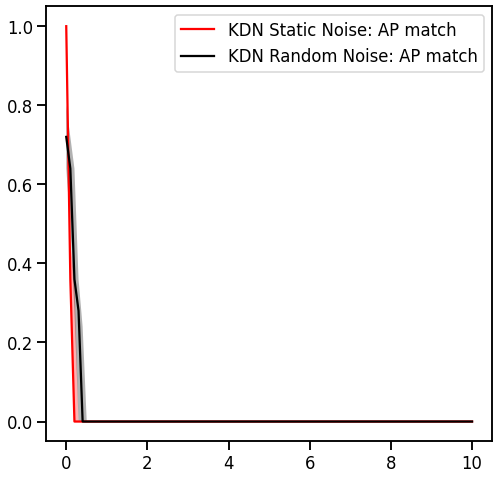

In [32]:
methods = ["TM", "FM", "LL", "AP"]

for method in methods:
    # plot distance vs. weights for KDN
    weights_s = [get_kdn_weights(X_star, X_dist_static[d], model_kdn, method) for d in distances]
    weight_med_s = [np.median(w) for w in weights_s]
    weight_25q_s = [np.quantile(w, 0.25) for w in weights_s]
    weight_75q_s = [np.quantile(w, 0.75) for w in weights_s]

    weights_n = [get_kdn_weights(X_star, X_dist_noisy[d], model_kdn, method) for d in distances]
    weight_med_n = [np.median(w) for w in weights_n]
    weight_25q_n = [np.quantile(w, 0.25) for w in weights_n]
    weight_75q_n = [np.quantile(w, 0.75) for w in weights_n]

    sns.set_context('talk')

    fig, ax = plt.subplots(1,1, figsize=(8,8))
    #ax.set_xscale("log")
    ax.plot(distances, weight_med_s, c="r", label=f'KDN Static Noise: {method} match')
    ax.plot(distances, weight_med_n, c="k", label=f'KDN Random Noise: {method} match')
    ax.fill_between(distances, weight_25q_s, weight_75q_s, facecolor='r', alpha=.3)
    ax.fill_between(distances, weight_25q_n, weight_75q_n, facecolor='k', alpha=.3)
    ax.legend()

In [33]:
distances = [0.01, 0.1, 1, 2, 5]
n_test = 10
for d in distances:
  print(d)
  rand_dist = rng.random((n_test, p_star))
  rand_dist = np.sqrt(d**2*(rand_dist/np.sum(rand_dist, axis=1)[:,None]))
  #print(rand_dist)
  print(np.sqrt(np.sum(rand_dist**2, axis=1)))

0.01
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
0.1
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
1
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
2
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
5
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
